# Day 44

Continuing my work from yesterday. The goal today is to remove QBs from the data, clean up the code for plotting, and bin the picks so I can have more accurate bootstrapped distributions.

Query Updates
- Update rankings to not include QBs

In [393]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Position by Round

In [394]:
query = """
SELECT
    position, 
    SUBSTR(adp_formatted,1,1) AS round, 
    count(*) AS num_selections
FROM adp
WHERE position IN ('QB', 'WR', 'RB')
    AND round IN ('1', '2', '3')
GROUP BY position, round
"""

df = pd.read_sql(query, conn)

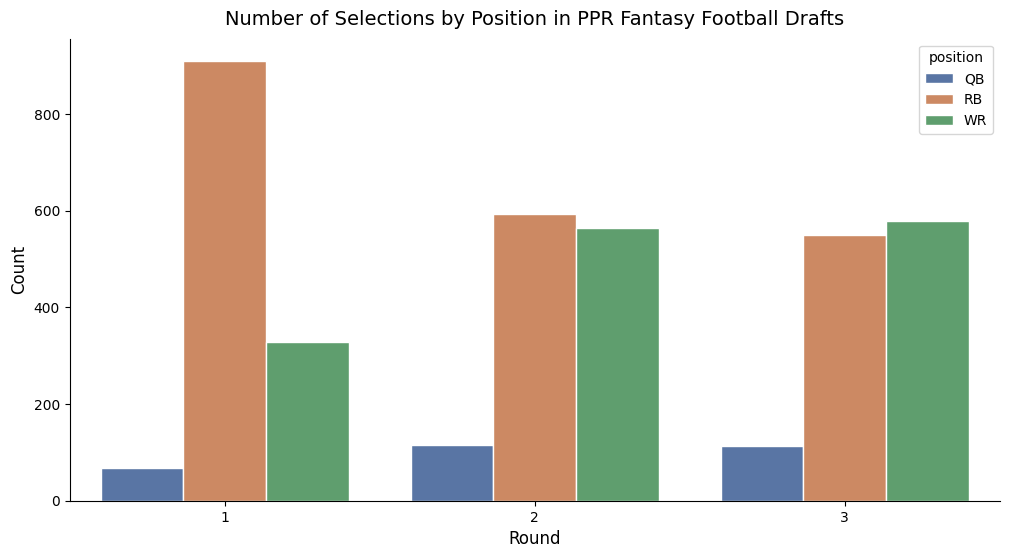

In [395]:
# Change plot size
plt.figure(figsize = (12, 6))

g = sns.barplot(data=df,
            x='round',
            y='num_selections',
            hue='position',
            edgecolor="1"
            )

# Add labels and title
g.set_xlabel("Round", size=12)
g.set_ylabel("Count", size=12)
g.set_title("Number of Selections by Position in PPR Fantasy Football Drafts", size=14, pad=10)

sns.despine()

QBs should be filtered out of the dataset. They are rarely picked in the first round and tend to finish at the top of end-of-season rankings. By including them it makes the RBs and WRs picked in Rounds 1-2 look worse.

## Query the Data

In [396]:
query = """
WITH adp_cleaned AS (
    SELECT
        scoring,
        season,
        teams AS league_size,
        CASE
            WHEN player_id = 2071 AND name = 'CJ Anderson' THEN 'C.J. Anderson'
            ELSE name
        END AS player_name,
        position AS pos,
        /*
        ADP dataset has the most recent team that a player has played for, regardless of season.
        So I'll need to update teams for certain player-season combinations in order to join
        against the nflverse data which contains the player's fantasy points by season
        */
        CASE
            WHEN player_id = 1347 AND name = 'Chris Johnson' THEN 'TEN'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season < 2015 THEN 'BUF'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season = 2015 THEN 'SEA'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season < 2014 THEN 'BUF'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season = 2015 THEN 'NO'
            WHEN player_id = 649 AND name = 'Maurice Jones-Drew' AND season < 2014 THEN 'JAX'
            WHEN player_id = 1105 AND name = 'Darren Sproles' AND season = 2013 THEN 'NO'
            WHEN player_id = 581 AND name = 'Steven Jackson' AND season = 2012 THEN 'LAR'
            ELSE team
        END AS team,
        adp_formatted,
        round,
        pick
    FROM adp
    WHERE position <> 'QB'),
season_summary AS (
    SELECT
        player_id,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN player_display_name = "Le'Veon Bell" THEN "LeVeon Bell"
            WHEN player_display_name = "Odell Beckham" THEN "Odell Beckham Jr"
            WHEN player_display_name = "Mike Vick" THEN "Michael Vick"
            WHEN player_display_name = "DK Metcalf" THEN "D.K. Metcalf"
            ELSE player_display_name
        END AS player_name,
        season,
        -- Data Cleaning for future join against ADP table
        CASE 
            WHEN player_id = "00-0029675" AND player_display_name = "Trent Richardson" THEN "RB"
            ELSE position
        END AS pos,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN recent_team = 'LA' THEN 'LAR'
            ELSE recent_team
        END AS team,
        ROUND(SUM(fantasy_points), 2) AS tot_pts,
        ROUND(SUM(fantasy_points_ppr), 2) AS tot_pts_ppr
    FROM 
        /* 
        The ADP table that I will eventually join against has the last team a player
        played for in a given season. In the case of players that were traded 
        at least once in a season, if I group by player name with player-week records in
        ascending order (by week) I'll get their earliest team. So I need to order by 
        most recent week to get the last team they played for when I aggregate.
        */
        (
            SELECT  *
            FROM weekly
            ORDER BY week DESC 
        ) AS weekly
    WHERE season_type = 'REG' 
        AND player_display_name IS NOT NULL
        AND pos <> 'QB'
    GROUP BY player_id, player_display_name, season),
rankings AS (
    SELECT
        *,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts DESC) AS r_pts,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts_ppr DESC) AS r_pts_ppr
    FROM season_summary), 
joined AS (   
    SELECT
        adp_cleaned.*, 
        rankings.*, 
        weeks_injured
    FROM adp_cleaned
    LEFT JOIN rankings
        ON rankings.player_name = adp_cleaned.player_name
        AND rankings.season = adp_cleaned.season
        -- Additional join keys added in case multiple players have same name
        AND rankings.pos = adp_cleaned.pos
        AND rankings.team = adp_cleaned.team
    LEFT JOIN (
        SELECT *, COUNT(*) AS weeks_injured
        FROM injuries
        WHERE practice_status LIKE 'OUT%'
            OR (practice_status LIKE 'Did Not Participate%'
                -- Need to check for players who were just resting
                AND LOWER(practice_primary_injury) NOT LIKE '%not injury related%') 
        GROUP BY season, full_name, team, position
    ) AS injuries
        ON injuries.season = adp_cleaned.season
        AND injuries.full_name = adp_cleaned.player_name
        -- Additional join keys added in case multiple players have same name
        AND injuries.team = adp_cleaned.team
        AND injuries.position = adp_cleaned.pos),
first_and_second_round_picks AS (
    SELECT
        scoring,
        season,
        league_size,
        player_id,
        player_name,
        pos,
        team,
        adp_formatted,
        tot_pts_ppr,
        -- r_pts,
        r_pts_ppr,
        COALESCE(weeks_injured, 0) AS weeks_injured  -- replace NULL values with 0
    FROM joined
    WHERE round = 1
        OR round = 2)
SELECT * 
FROM first_and_second_round_picks
WHERE scoring = 'ppr'
    --AND league_size BETWEEN 10 AND 12
"""

df = pd.read_sql(query, conn)
df.head()

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
0,ppr,2010,8,00-0026164,Chris Johnson,RB,TEN,1.01,272.9,12.0,0
1,ppr,2010,8,00-0025394,Adrian Peterson,RB,MIN,1.02,275.9,10.0,0
2,ppr,2010,8,00-0026195,Ray Rice,RB,BAL,1.03,276.6,9.0,0
3,ppr,2010,8,00-0024275,Maurice Jones-Drew,RB,JAX,1.05,234.1,26.0,2
4,ppr,2010,8,00-0022044,Andre Johnson,WR,HOU,1.05,256.6,16.0,3


In [397]:
df[df['r_pts_ppr'].isnull()]

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
119,ppr,2018,8,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0
334,ppr,2018,10,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0
589,ppr,2018,12,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0
888,ppr,2018,14,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0


I couldn't find end-of-season fantasy rankings for a single player – Le'Veon Bell in 2018. In 2018 Le'Veon sat out for the entire season due to contract disputes. Fantasy managers who picked him in the first round thinking that he'd eventually play ended up making a really poor bet!

In [398]:
df.describe().round(2)

,season,league_size,tot_pts_ppr,r_pts_ppr,weeks_injured
count,997.00,997.00,993.00,993.00,997.00
mean,2015.72,11.44,226.88,53.57,1.17
std,3.41,2.20,89.20,73.80,1.86
min,2010.00,8.00,9.00,1.00,0.00
25%,2013.00,10.00,174.80,9.00,0.00
50%,2016.00,12.00,230.20,26.00,0.00
75%,2019.00,14.00,295.20,63.00,2.00
max,2021.00,14.00,471.20,382.00,11.00


## Cleaning

In [399]:
def get_pick(row):
    """
    Given ADP in the format of X.XX (round.pick), get the sequential pick number
    """
    
    round = int(row['adp_formatted'].split('.')[0])

    if round == 1:
        pick = int(row['adp_formatted'].split('.')[1])
    else:
        if row['league_size'] == 8:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 6
        elif row['league_size'] == 10:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 8
        elif row['league_size'] == 12:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 10
        elif row['league_size'] == 14:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 12

    return pick

df['pick'] = df.apply(lambda row: get_pick(row), axis=1)

In [400]:
# Remove outliers (players with season-ending injuries that happened early into the season)
df_rm_outliers = df.query("r_pts_ppr <= 75")

## Exploratory Data Analysis

In [401]:
order = list(df.adp_formatted.unique())
order.sort()
order[:5]

['1.01', '1.02', '1.03', '1.04', '1.05']

In [402]:
df_rm_outliers.describe().round(2)

,season,league_size,tot_pts_ppr,r_pts_ppr,weeks_injured,pick
count,768.00,768.00,768.00,768.00,768.00,768.00
mean,2015.68,11.43,263.68,22.35,0.74,11.79
std,3.44,2.20,60.70,18.84,1.15,6.91
min,2010.00,8.00,158.40,1.00,0.00,1.00
25%,2013.00,10.00,215.00,7.00,0.00,6.00
50%,2016.00,12.00,256.60,16.00,0.00,11.00
75%,2019.00,14.00,305.50,33.00,1.00,17.00
max,2021.00,14.00,471.20,75.00,6.00,28.00


In [403]:
df_rm_outliers.query("weeks_injured > 3").head(10)

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured,pick
64,ppr,2014,8,00-0027942,A.J. Green,WR,CIN,2.03,205.3,40.0,4,11
81,ppr,2015,8,00-0025389,Calvin Johnson,WR,DET,2.05,261.4,13.0,4,13
90,ppr,2016,8,00-0027942,A.J. Green,WR,CIN,1.06,186.4,59.0,4,6
104,ppr,2017,8,00-0027793,Antonio Brown,WR,PIT,1.04,310.3,4.0,4,4
137,ppr,2019,8,00-0031381,Davante Adams,WR,GB,1.06,212.7,43.0,4,6
155,ppr,2020,8,00-0036360,Clyde Edwards-Helaire,RB,KC,1.06,176.0,63.0,4,6
229,ppr,2012,10,00-0027656,Rob Gronkowski,TE,NE,2.07,198.0,43.0,4,17
263,ppr,2014,10,00-0027942,A.J. Green,WR,CIN,2.01,205.3,40.0,4,11
283,ppr,2015,10,00-0025389,Calvin Johnson,WR,DET,2.03,261.4,13.0,4,13
295,ppr,2016,10,00-0027942,A.J. Green,WR,CIN,1.06,186.4,59.0,4,6


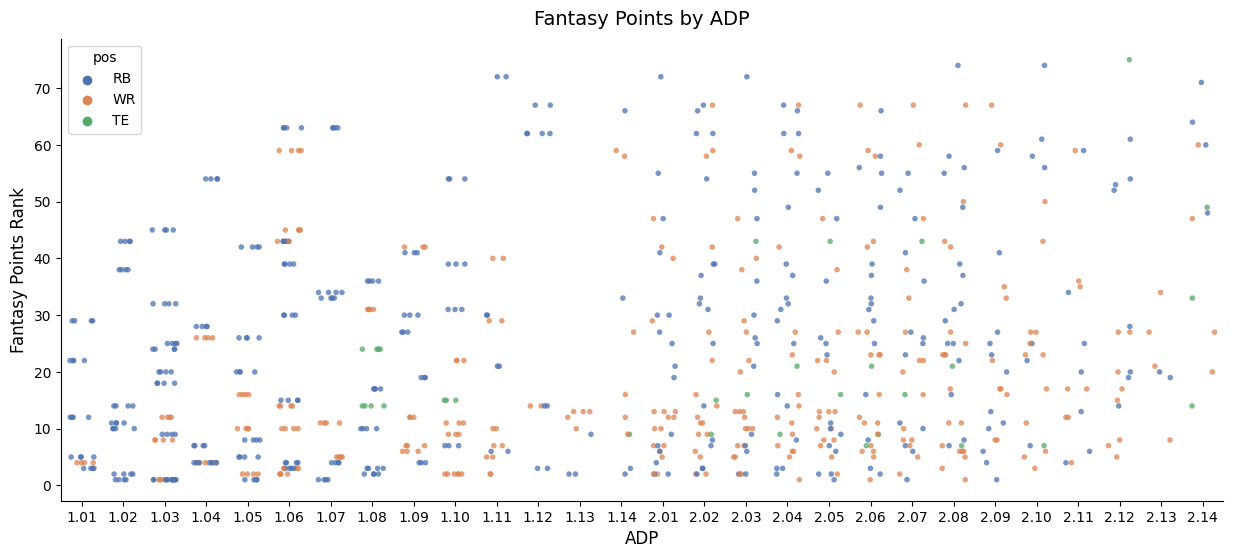

In [404]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.stripplot(data=df_rm_outliers,
                  x='adp_formatted',
                  y='r_pts_ppr',
                  jitter=0.30,
                  size=4,
                  alpha=0.75,
                  hue='pos',
                  order=order)

# Add labels and title
g.set_xlabel("ADP", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

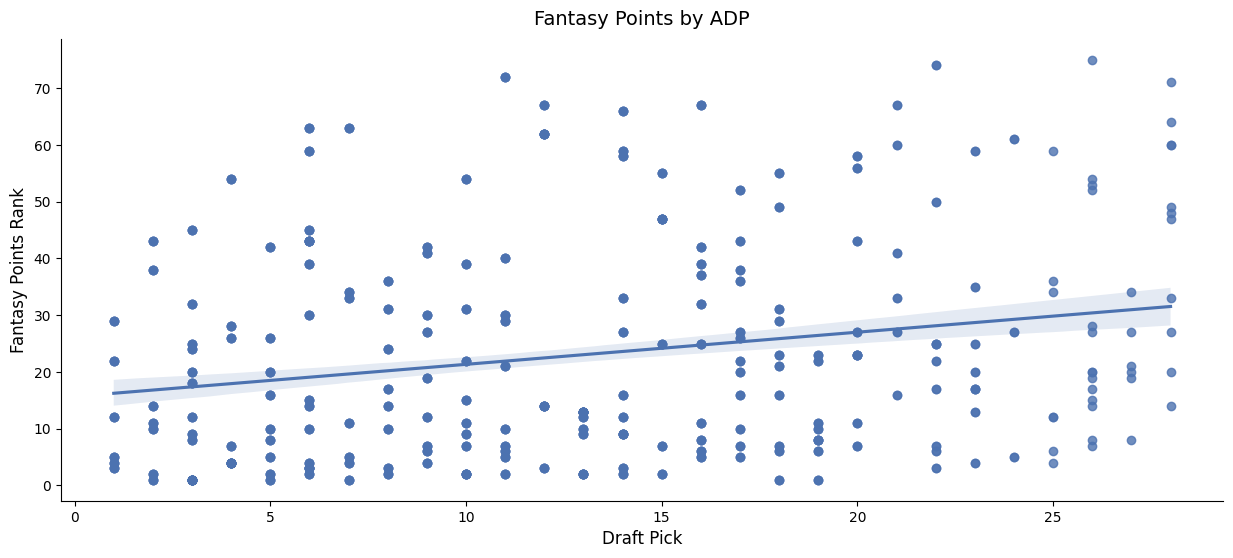

In [405]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.regplot(data=df_rm_outliers,
            x='pick',
            y='r_pts_ppr')

# Add labels and title
g.set_xlabel("Draft Pick", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

In [406]:
# Check correlation coefficient
df_rm_outliers.pick.corr(df_rm_outliers.r_pts_ppr).round(2)

0.21

There is a very weak positive correlation between draft pick and end of season fantasy points ranking, at least for the first two rounds of a fantasy draft.

In [407]:
# Number of players by ADP
df_rm_outliers['adp_formatted'].value_counts().sort_index()

1.01    24
1.02    28
1.03    52
1.04    28
1.05    36
1.06    56
1.07    28
1.08    32
1.09    27
1.10    30
1.11    20
1.12    12
1.13     8
1.14    11
2.01    33
2.02    37
2.03    36
2.04    37
2.05    34
2.06    39
2.07    32
2.08    37
2.09    22
2.10    20
2.11    15
2.12    17
2.13     6
2.14    11
Name: adp_formatted, dtype: int64

In [408]:
# Number of players by Pick
df_rm_outliers['pick'].value_counts().sort_index()

1     24
2     28
3     52
4     28
5     36
6     56
7     28
8     32
9     36
10    40
11    40
12    24
13    32
14    44
15    24
16    40
17    36
18    30
19    24
20    24
21    12
22    18
23    16
24     6
25     7
26    14
27     6
28    11
Name: pick, dtype: int64

Sample sizes are still small but much better after adding ADP data from 8 and 14 team leagues. I might need to cap the analysis to picks 1-20 as there is a noticeable drop-off in available data after pick 20.

I'll continue with bootstrap sampling.

### Run Bootstrap Simulations

In [409]:
def generate_bootstrap_distribution(n, df):
    
    # Get sample means
    bootstrap_dist = []
    for i in range(n):
        bootstrap_dist.append(
            # Get point estimate
            np.mean(
                # Resample
                df.sample(frac=1, replace=True)['r_pts_ppr']
            )
        )
    return bootstrap_dist

In [410]:
bootstrap_results = {}

for pick in range(1, 25):
    bootstrap_results[str(pick)] = generate_bootstrap_distribution(10000, df_rm_outliers.query(f"pick == {pick}"))

df_boot_results = pd.DataFrame(bootstrap_results)

In [411]:
df_boot_results.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,14.666667,20.750000,14.269231,14.857143,13.611111,24.946429,25.392857,15.87500,17.638889,16.450,...,37.000000,32.825,26.777778,22.166667,13.375000,28.625000,34.250000,28.388889,21.8750,44.000000
1,13.458333,16.142857,18.557692,16.571429,12.638889,29.107143,21.178571,14.59375,23.527778,19.825,...,34.041667,31.500,29.083333,27.000000,12.250000,28.500000,40.916667,20.000000,25.3125,21.666667
2,11.375000,20.964286,14.115385,19.535714,18.666667,25.571429,16.750000,17.00000,20.444444,21.300,...,34.125000,27.825,23.000000,27.033333,7.791667,32.250000,47.833333,20.333333,28.1875,21.666667
3,10.791667,20.357143,13.480769,13.392857,18.083333,22.750000,21.107143,16.31250,21.472222,18.150,...,24.625000,26.250,22.083333,21.600000,11.000000,32.333333,46.083333,29.444444,20.0000,31.000000
4,13.208333,17.535714,13.923077,24.107143,12.888889,28.160714,28.214286,12.90625,23.444444,21.800,...,32.333333,25.050,26.638889,19.666667,12.416667,29.166667,44.333333,35.055556,29.3125,31.000000


In [412]:
# Convert from wide to long to make it easier to plot
df_boot_melted = pd.melt(df_boot_results, var_name='pick', value_name='mean_ppr_ranking')
df_boot_melted['pick'] = df_boot_melted['pick'].astype(int)

In [413]:
# Use list comprehension to subset columns
cols = [str(col) for col in df_boot_results.columns]

# First ten picks
df_boot_results[cols[:10]].describe().round(2)

,1,2,3,4,5,6,7,8,9,10
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,12.48,17.02,15.16,18.13,14.47,26.61,21.54,17.10,20.86,19.21
std,2.04,2.98,1.85,3.35,2.09,2.86,3.94,2.04,2.32,2.62
min,5.54,5.96,8.83,5.29,7.31,16.91,8.79,9.53,12.17,9.75
25%,11.08,14.96,13.88,15.79,13.03,24.66,18.79,15.69,19.28,17.40
50%,12.46,16.93,15.13,18.04,14.42,26.57,21.43,17.06,20.86,19.15
75%,13.83,19.00,16.35,20.39,15.83,28.52,24.21,18.50,22.40,20.95
max,20.58,29.32,22.67,31.14,23.89,37.07,37.32,25.09,29.78,29.48


In [414]:
# Picks 11-24
df_boot_results[cols[10:]].describe().round(2)

,11,12,13,14,15,16,17,18,19,20,21,22,23,24
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,22.14,37.04,9.24,26.74,30.47,27.15,25.17,23.80,11.12,31.04,40.67,25.49,23.71,30.99
std,3.24,5.52,0.78,3.45,4.16,2.99,2.33,3.11,1.47,3.71,5.15,5.18,3.97,9.44
min,12.30,16.08,5.84,14.86,14.83,15.68,16.56,12.93,6.12,18.62,23.17,9.28,11.00,5.00
25%,19.85,33.25,8.72,24.39,27.71,25.10,23.58,21.63,10.12,28.50,37.08,21.78,20.94,25.33
50%,22.00,37.00,9.25,26.61,30.50,27.10,25.17,23.70,11.12,31.04,40.67,25.28,23.50,31.00
75%,24.32,40.79,9.78,29.09,33.33,29.18,26.75,25.87,12.08,33.50,44.08,28.83,26.25,36.67
max,35.30,57.21,11.84,40.52,43.96,38.22,34.25,36.40,16.75,46.25,63.08,48.22,39.56,61.00


#### Distributions

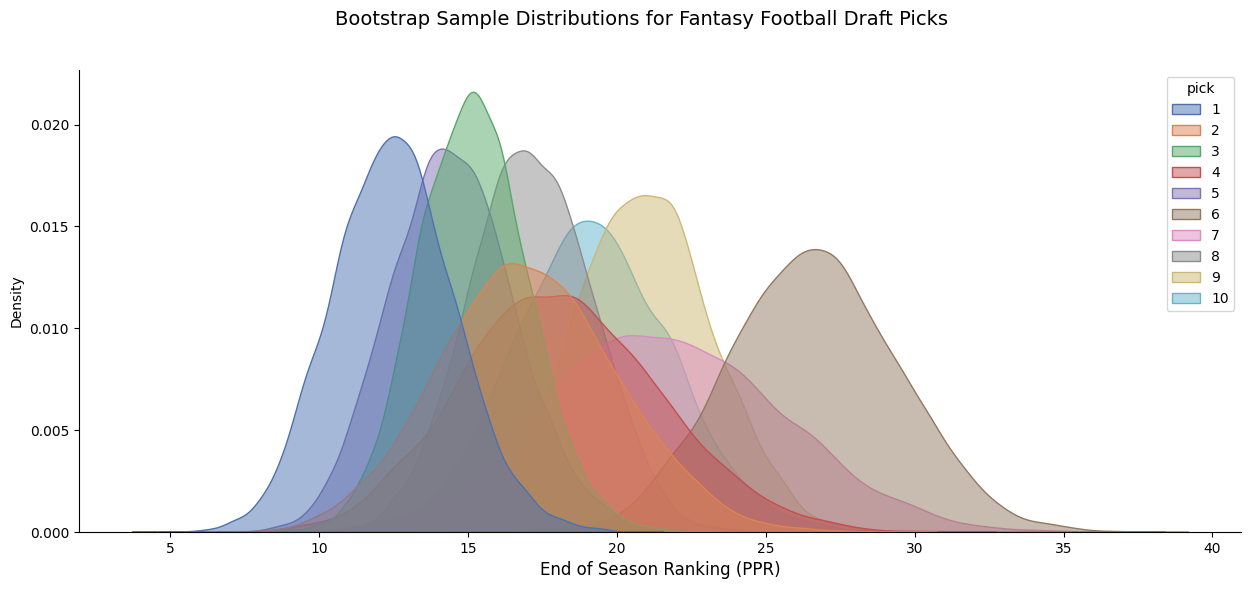

In [415]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

# Confirm sample means are normally distributed
g = sns.kdeplot(df_boot_melted.query("pick <= 10"), 
                x='mean_ppr_ranking',
                fill=True,
                alpha=0.5, 
                hue='pick',
                palette='deep',
                ax=ax)

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

There's a lot of overlap and picks do not rank-order on end-of-season rankings

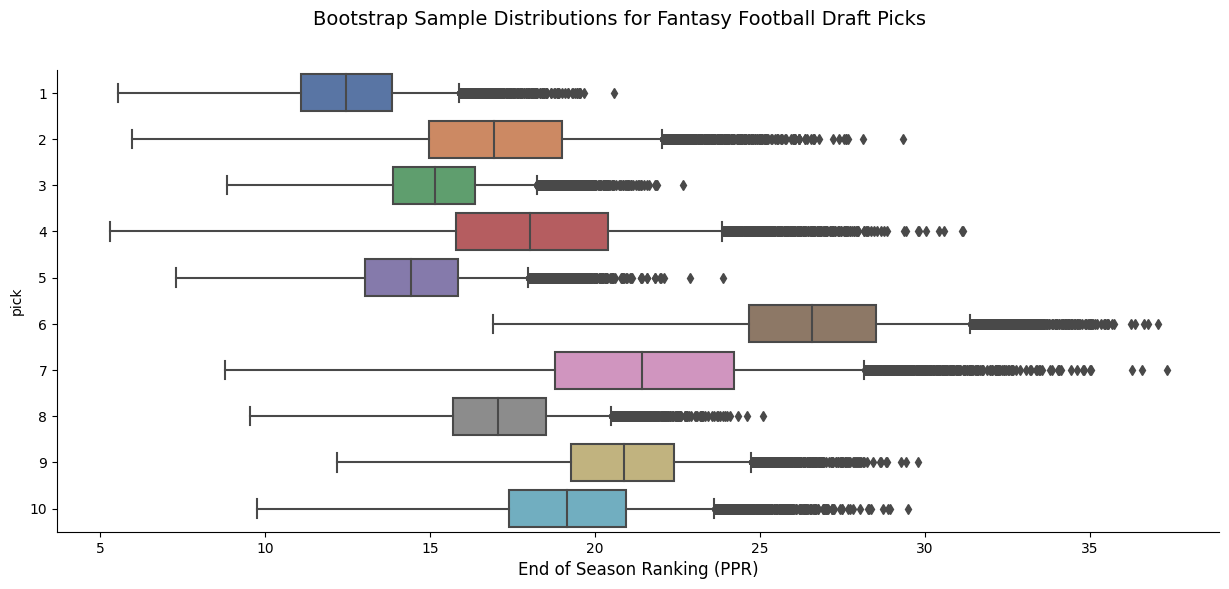

In [416]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

# Show boxplots with 95% confidence intervals
sns.boxplot(df_boot_melted.query("pick <= 10"),
                x='mean_ppr_ranking',
                y=df_boot_melted.query("pick <= 10")['pick'].astype(str),
                whis=[0,95])

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

Another way of viewing the distribution. Pick 1 looks the best with the lowest median and 95% confidence interval.  

Pick 5 looks surprisingly good.

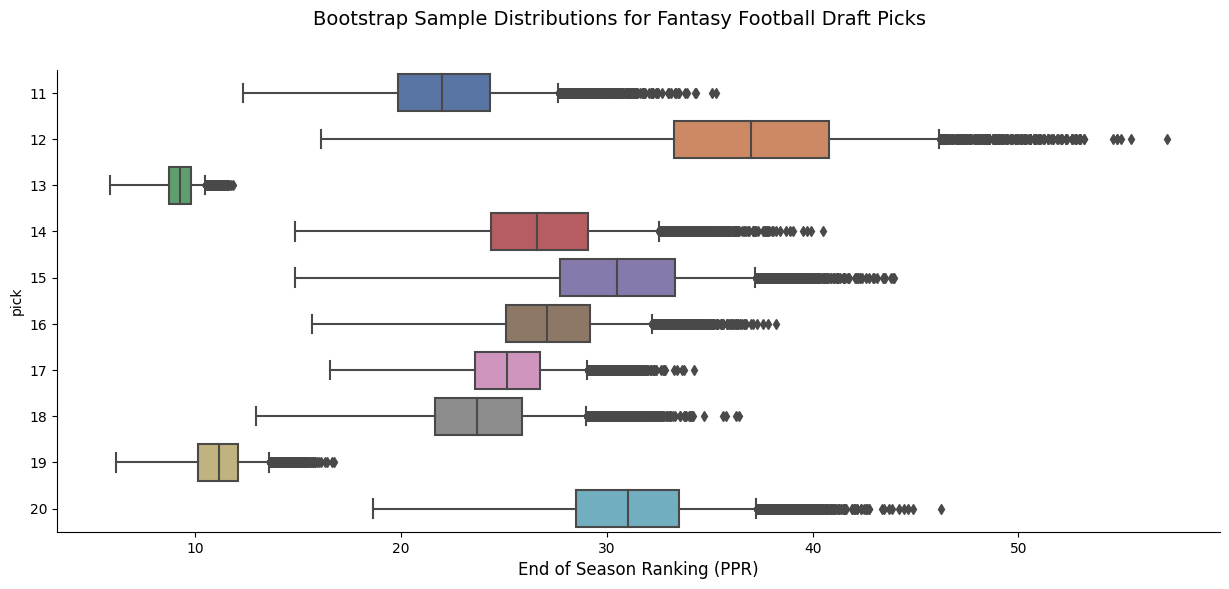

In [417]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

# Show boxplots with 95% confidence intervals
sns.boxplot(df_boot_melted.query("pick > 10 & pick <= 20"),
                x='mean_ppr_ranking',
                y=df_boot_melted.query("pick > 10 & pick <= 20")['pick'].astype(str),
                whis=[0,95])

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

Picks 13 and 19 look surprisingly good. 

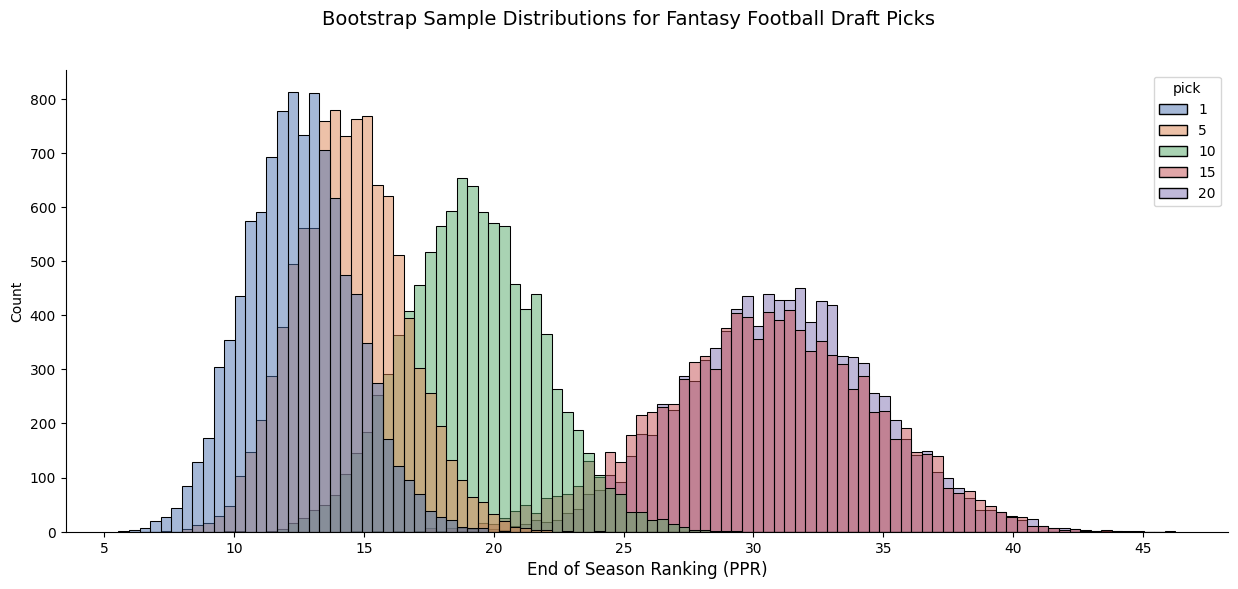

In [418]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

sns.histplot(df_boot_melted.query("pick == 1 | pick % 5 == 0"), 
             x='mean_ppr_ranking', 
             bins=100, 
             alpha=0.5, 
             hue='pick',
             palette='deep')

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

The bootstrap distributions make it easy to see the difference between not only the performances of players taken in the 1st and 2nd rounds, but also players taken within the 1st round – there's a noticeable drop off between Picks 1-5 and Pick 10.

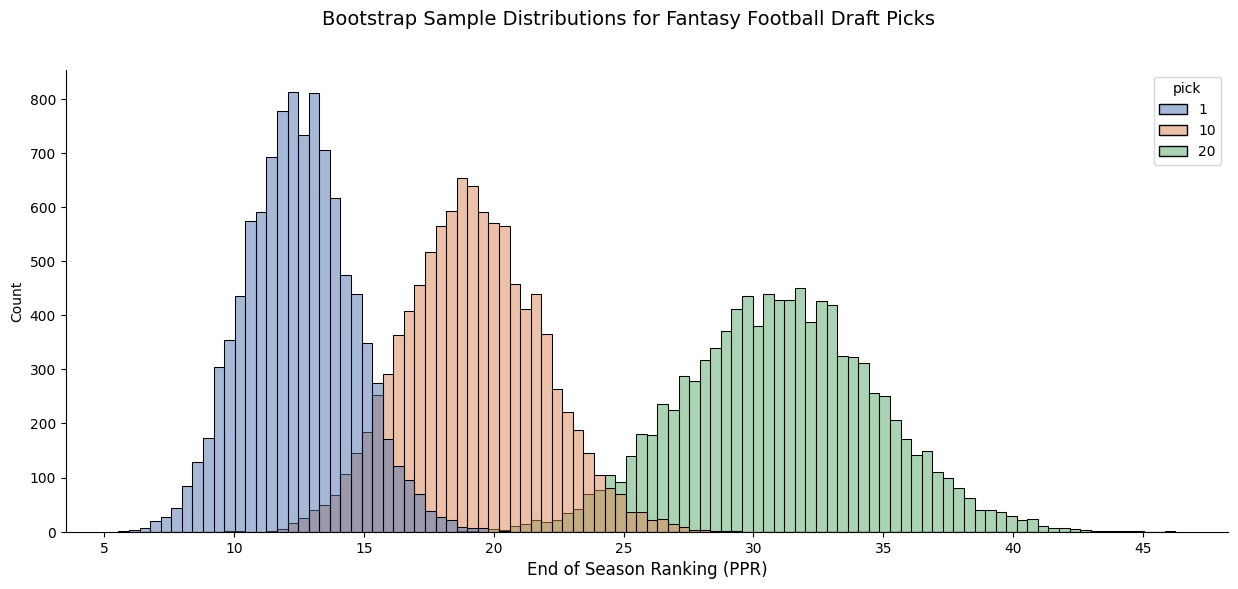

In [419]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

sns.histplot(df_boot_melted.query("pick == 1 | pick % 10 == 0"), 
             x='mean_ppr_ranking', 
             bins=100, 
             alpha=0.5, 
             hue='pick',
             palette='deep')

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

## Grouping Picks Together

I'll group (bin) the picks in groups of 2 (picks 1-2, 3-4, etc) to start with and see how the distributions compare. This should hopefully reduce some of the noise I'm seeing.

In [420]:
bins1 = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
labels1 = ['Picks 1-2', 'Picks 3-4', 'Picks 5-6', 'Picks 7-8', 'Picks 9-10',
          'Picks 11-12', 'Picks 13-14', 'Picks 15-16', 'Picks 17-18', 'Picks 19-20' ]

df_rm_outliers['pick_bin'] = pd.cut(df_rm_outliers['pick'], 
                                    bins=bins1, 
                                    right=False, 
                                    include_lowest=True,
                                    labels=labels1)

# Validate
pd.crosstab(df_rm_outliers['pick'], df_rm_outliers['pick_bin'])

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_45795/350967952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rm_outliers['pick_bin'] = pd.cut(df_rm_outliers['pick'],


pick_bin,Picks 1-2,Picks 3-4,Picks 5-6,Picks 7-8,Picks 9-10,Picks 11-12,Picks 13-14,Picks 15-16,Picks 17-18,Picks 19-20
pick,,,,,,,,,,
1,24,0,0,0,0,0,0,0,0,0
2,28,0,0,0,0,0,0,0,0,0
3,0,52,0,0,0,0,0,0,0,0
4,0,28,0,0,0,0,0,0,0,0
5,0,0,36,0,0,0,0,0,0,0
6,0,0,56,0,0,0,0,0,0,0
7,0,0,0,28,0,0,0,0,0,0
8,0,0,0,32,0,0,0,0,0,0
9,0,0,0,0,36,0,0,0,0,0


In [421]:
df_rm_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   scoring        768 non-null    object  
 1   season         768 non-null    int64   
 2   league_size    768 non-null    int64   
 3   player_id      768 non-null    object  
 4   player_name    768 non-null    object  
 5   pos            768 non-null    object  
 6   team           768 non-null    object  
 7   adp_formatted  768 non-null    object  
 8   tot_pts_ppr    768 non-null    float64 
 9   r_pts_ppr      768 non-null    float64 
 10  weeks_injured  768 non-null    int64   
 11  pick           768 non-null    int64   
 12  pick_bin       678 non-null    category
dtypes: category(1), float64(2), int64(4), object(6)
memory usage: 79.1+ KB


Null values are expected since I'm only binning picks 1-20 (due to low counts for picks 21-24)

In [422]:
# Remove nulls
df_pick_bins = df_rm_outliers.dropna()

df_pick_bins.pick_bin.unique()

['Picks 1-2', 'Picks 3-4', 'Picks 5-6', 'Picks 9-10', 'Picks 11-12', 'Picks 13-14', 'Picks 15-16', 'Picks 7-8', 'Picks 17-18', 'Picks 19-20']
Categories (10, object): ['Picks 1-2' < 'Picks 3-4' < 'Picks 5-6' < 'Picks 7-8' ... 'Picks 13-14' < 'Picks 15-16' < 'Picks 17-18' < 'Picks 19-20']

### Run Bootstrap Simulations

In [423]:
def generate_bootstrap_distribution(n, df):
    
    # Get sample means
    bootstrap_dist = []
    for i in range(n):
        bootstrap_dist.append(
            # Get point estimate
            np.mean(
                # Resample
                df.sample(frac=1, replace=True)['r_pts_ppr']
            )
        )
    return bootstrap_dist

In [424]:
bootstrap_results = {}

for pick_bin in df_pick_bins.pick_bin.unique():
    bootstrap_results[pick_bin] = generate_bootstrap_distribution(10000, df_pick_bins.query(f"pick_bin == '{pick_bin}'"))

df_bootstrap_pick_bins = pd.DataFrame(bootstrap_results)

In [425]:
df_bootstrap_pick_bins.head()

,Picks 1-2,Picks 3-4,Picks 5-6,Picks 9-10,Picks 11-12,Picks 13-14,Picks 15-16,Picks 7-8,Picks 17-18,Picks 19-20
0,12.673077,17.1375,23.434783,20.276316,29.531250,16.368421,27.921875,20.316667,23.424242,21.104167
1,12.115385,14.9250,21.880435,19.947368,21.453125,20.460526,27.968750,16.833333,26.772727,26.229167
2,14.711538,17.7875,24.858696,16.171053,29.703125,21.092105,33.718750,19.633333,22.272727,17.125000
3,13.769231,18.3875,26.315217,21.328947,31.906250,17.434211,29.718750,19.116667,23.878788,24.791667
4,14.096154,16.3000,19.673913,21.842105,30.531250,18.263158,26.703125,22.383333,24.848485,20.770833


In [426]:
# Convert from wide to long to make it easier to plot
df_bootstrap_pick_bins_melted = pd.melt(df_bootstrap_pick_bins, var_name='pick_bin', value_name='mean_ppr_ranking')
df_bootstrap_pick_bins_melted['pick_bin'] = df_bootstrap_pick_bins_melted['pick_bin'].astype(str)

In [427]:
df_bootstrap_pick_bins_melted.head()

,pick_bin,mean_ppr_ranking
0,Picks 1-2,12.673077
1,Picks 1-2,12.115385
2,Picks 1-2,14.711538
3,Picks 1-2,13.769231
4,Picks 1-2,14.096154


In [428]:
_01_to_10 = df_bootstrap_pick_bins_melted.query(f"pick_bin.isin({labels1[:5]})")
_11_to_20 = df_bootstrap_pick_bins_melted.query(f"pick_bin.isin({labels1[5:]})")

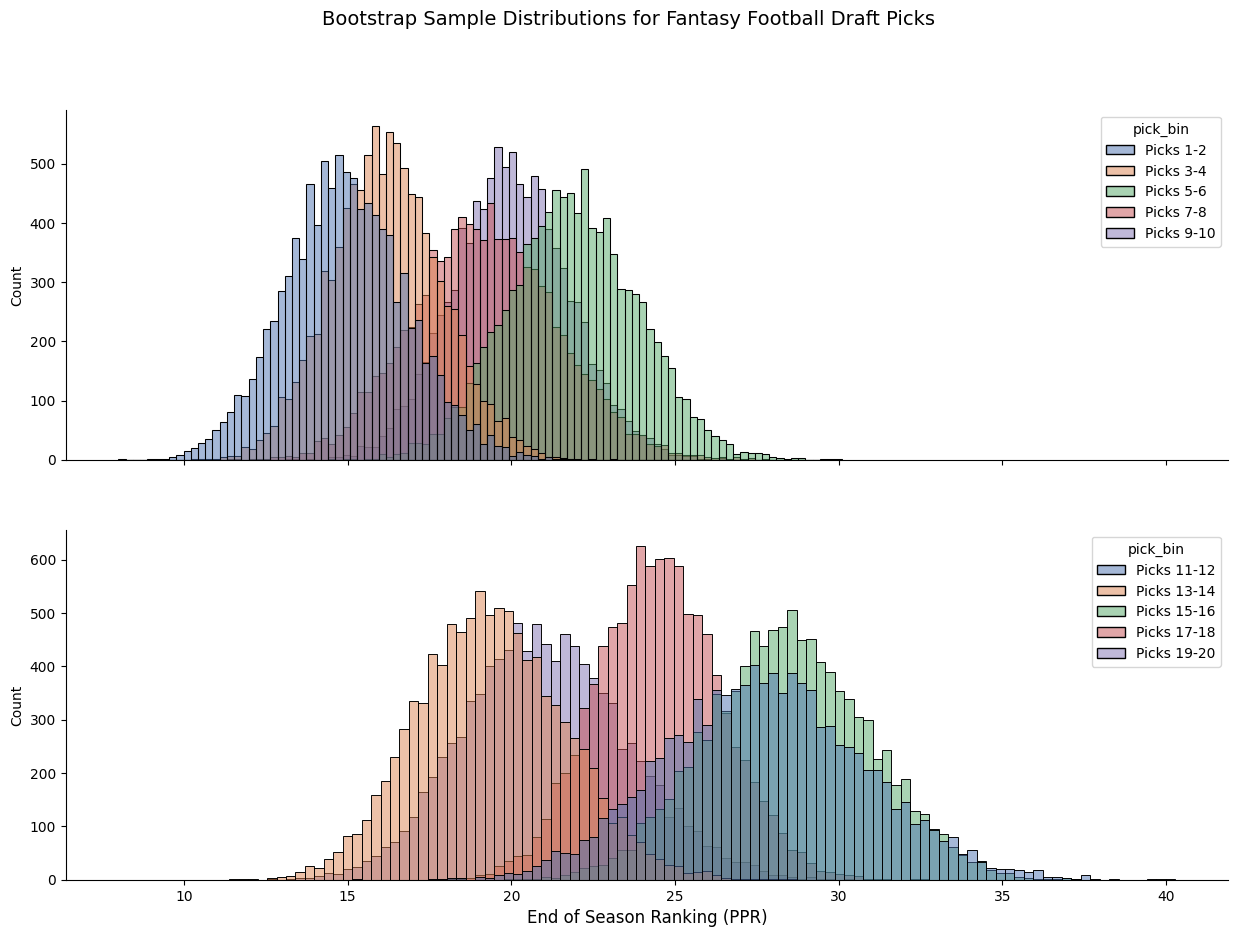

In [429]:
# Change plot size
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize = (15, 10))

sns.histplot(_01_to_10, 
                 x='mean_ppr_ranking', 
                 bins=100, 
                 alpha=0.5, 
                 hue='pick_bin',
                 palette='deep',
                 hue_order=labels1[:5],
                 ax=ax0)

sns.histplot(_11_to_20, 
                 x='mean_ppr_ranking', 
                 bins=100, 
                 alpha=0.5, 
                 hue='pick_bin',
                 palette='deep',
                 hue_order=labels1[5:],
                 ax=ax1)


plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

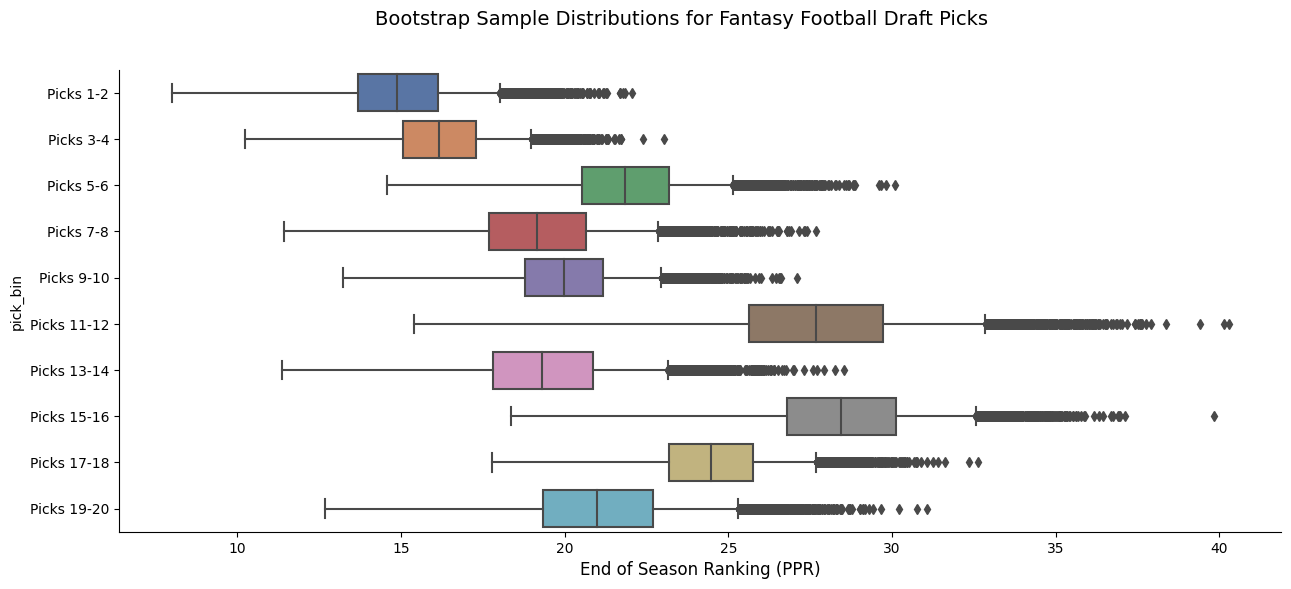

In [430]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

g = sns.boxplot(df_bootstrap_pick_bins_melted,
                x='mean_ppr_ranking',
                y=df_bootstrap_pick_bins_melted.pick_bin,
                order=labels1,
                whis=[0,95])

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

Players picked either 1 or 2 clearly outperform the rest.

### Groups of 5

In [431]:
bins2 = [1, 6, 11, 16, 21]
labels2 = ['Picks 1-5', 'Picks 6-10', 'Picks 11-15', 'Picks 16-20']

df_rm_outliers['pick_bin2'] = pd.cut(df_rm_outliers['pick'], 
                                     bins=bins2, 
                                     labels=labels2, 
                                     right=False, 
                                     include_lowest=True)

pd.crosstab(df_rm_outliers['pick'], df_rm_outliers['pick_bin2'])

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_45795/404235627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rm_outliers['pick_bin2'] = pd.cut(df_rm_outliers['pick'],


pick_bin2,Picks 1-5,Picks 6-10,Picks 11-15,Picks 16-20
pick,,,,
1,24,0,0,0
2,28,0,0,0
3,52,0,0,0
4,28,0,0,0
5,36,0,0,0
6,0,56,0,0
7,0,28,0,0
8,0,32,0,0
9,0,36,0,0


In [432]:
df_rm_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 996
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   scoring        768 non-null    object  
 1   season         768 non-null    int64   
 2   league_size    768 non-null    int64   
 3   player_id      768 non-null    object  
 4   player_name    768 non-null    object  
 5   pos            768 non-null    object  
 6   team           768 non-null    object  
 7   adp_formatted  768 non-null    object  
 8   tot_pts_ppr    768 non-null    float64 
 9   r_pts_ppr      768 non-null    float64 
 10  weeks_injured  768 non-null    int64   
 11  pick           768 non-null    int64   
 12  pick_bin       678 non-null    category
 13  pick_bin2      678 non-null    category
dtypes: category(2), float64(2), int64(4), object(6)
memory usage: 80.1+ KB


In [433]:
df_pick_bins = df_rm_outliers.dropna()
df_pick_bins.pick_bin2.unique()

['Picks 1-5', 'Picks 6-10', 'Picks 11-15', 'Picks 16-20']
Categories (4, object): ['Picks 1-5' < 'Picks 6-10' < 'Picks 11-15' < 'Picks 16-20']

#### Run Bootstrap Simulations

In [434]:
bootstrap_results = {}

for pick_bin in df_pick_bins.pick_bin2.unique():
    bootstrap_results[pick_bin] = generate_bootstrap_distribution(10000, df_pick_bins.query(f"pick_bin2 == '{pick_bin}'"))

df_boot_results_pick_bins = pd.DataFrame(bootstrap_results)

In [435]:
# Convert from wide to long to make it easier to plot
df_bootstrap_pick_bins_melted = pd.melt(df_boot_results_pick_bins, var_name='pick_bin', value_name='mean_ppr_ranking')
df_bootstrap_pick_bins_melted['pick_bin'] = df_bootstrap_pick_bins_melted['pick_bin'].astype(str)

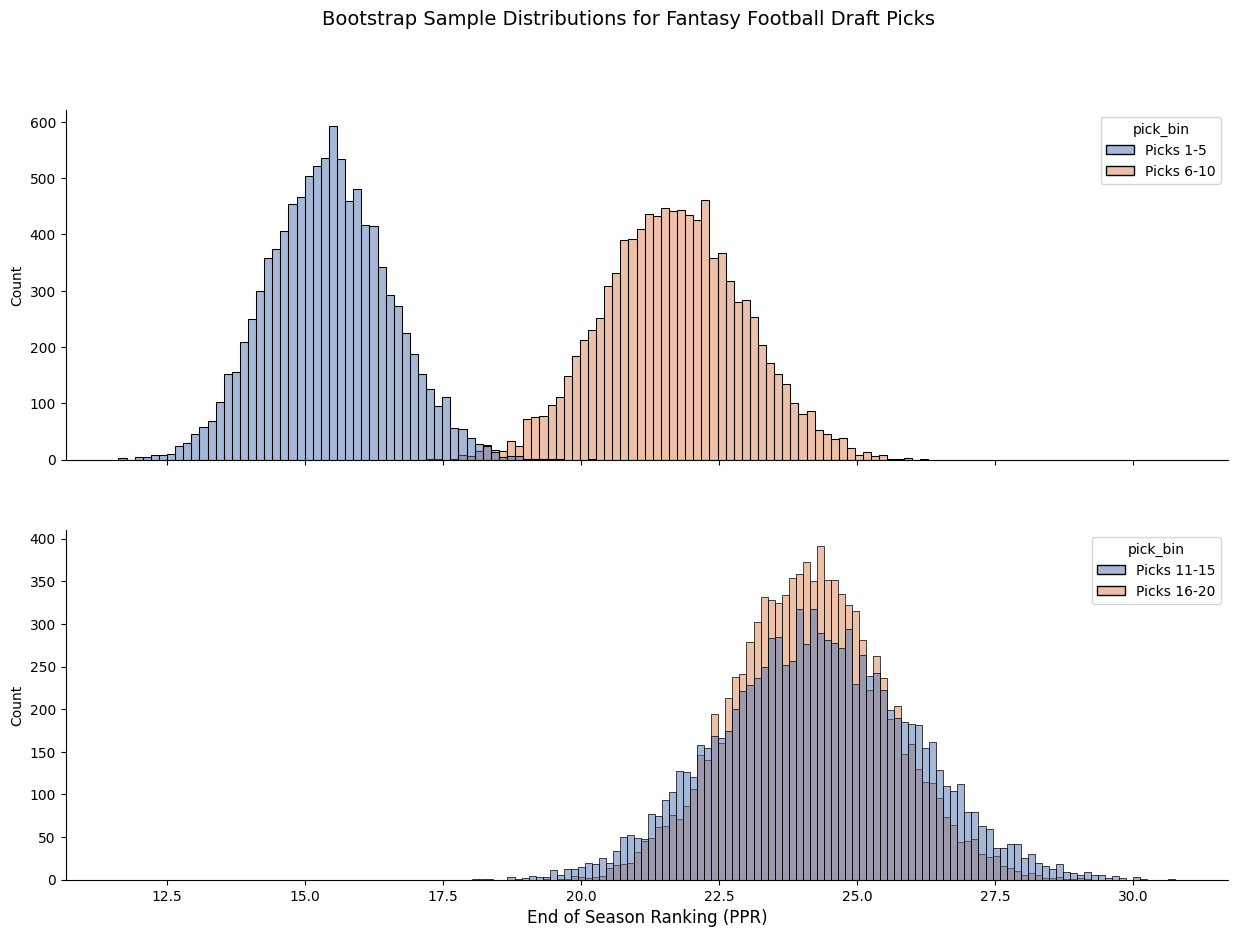

In [436]:
# Subset data
_01_to_10 = df_bootstrap_pick_bins_melted.query(f"pick_bin.isin({labels2[:2]})")
_11_to_20 = df_bootstrap_pick_bins_melted.query(f"pick_bin.isin({labels2[2:]})")

# Change plot size
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize = (15, 10))

sns.histplot(_01_to_10, 
             x='mean_ppr_ranking', 
             bins=100, 
             alpha=0.5, 
             hue='pick_bin',
             palette='deep',
             hue_order=labels2[:2],
             ax=ax0)

sns.histplot(_11_to_20, 
             x='mean_ppr_ranking', 
             bins=100, 
             alpha=0.5, 
             hue='pick_bin',
             palette='deep',
             hue_order=labels2[2:],
             ax=ax1)


plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

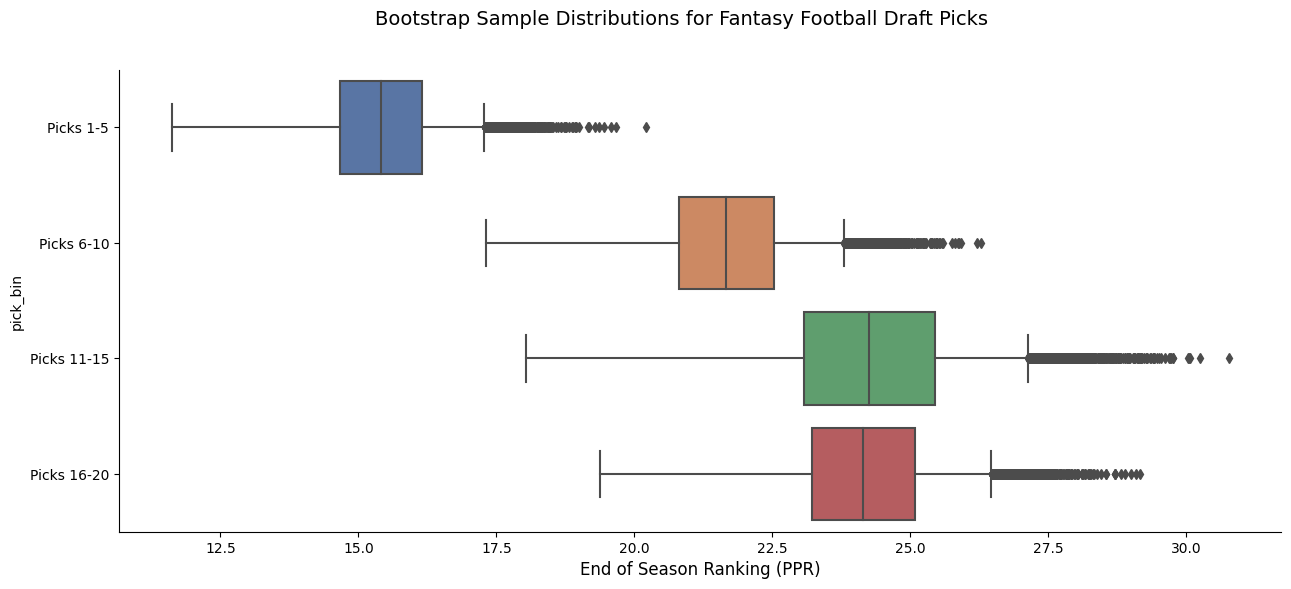

In [437]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

g = sns.boxplot(df_bootstrap_pick_bins_melted,
                x='mean_ppr_ranking',
                y=df_bootstrap_pick_bins_melted.pick_bin,
                order=labels2,
                whis=[0,95])

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

sns.despine()
plt.show()

When I group the picks in 5's I get a clean result – Picks 1-5 will nearly always outperform the next 5 picks and rank about 10 spots **higher** than 2nd Round picks.  

For 2nd Round picks, based on the data, it doesn't look like it matters at all where you draft. The players picked at these spots generally finish with the same ranking.